# Human Fall Detection

## Initialization

In [1]:
# Importing the libraries
import cv2
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Loading the detector
model = hub.load("https://tfhub.dev/google/movenet/multipose/lightning/1")
movenet = model.signatures['serving_default']

### Keypoints Drawing

In [3]:
# Draw the keypoints
def draw_keypoints(frame, keypoints, threshold=0.3):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > threshold:
            cv2.circle(frame,(int(kx),int(ky)), 4, (255,0,0), -1)

### Edge and Connection Drawing

In [4]:
edges = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [5]:
# Draw the skeleton
def draw_skeleton(frame, keypoints, edges, threshold=0.3):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        if (c1 > threshold) & (c2 > threshold):
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

### Boundaries Drawing

In [6]:
# Draw the bounding box
def draw_bounding_box(frame, keypoints, threshold=0.3):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))
    x1, y1, x2, y2 = x, y, 0, 0
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > threshold:
            x1, y1 = min(x1, kx), min(y1, ky)
            x2, y2 = max(x2, kx), max(y2, ky)
    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)

## Detections

### Human Detection

In [7]:
# Function to loop through each frame in the video
def loop_through_people(frame, keypoints_with_scores, edges, threshold):
    for person in keypoints_with_scores:
        draw_skeleton(frame, person, edges, threshold)
        draw_keypoints(frame, person, threshold)
        draw_bounding_box(frame, person, threshold)

### Fall Detection

In [8]:
# Analysis purposes
# Record coordinates of nose for each person
y_coordinates = {
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
}

x_coordinates = {
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
}

# Record aspect ratio of bounding box for each person
aspect_ratios = {
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
}

# Record angle of bounding box for each person
angles = {
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
}

# Record frame when person falls
fall_frames = {
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
}

Movenet only able to detect up to 6 person at a time. If there are more than 6 person, the program will only detect the first 6 person.

In [9]:
# Function to calculate aspect ratio of bounding box
def calculate_aspect_ratio(frame, keypoints_with_scores):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints_with_scores, [y, x, 1]))
    x1, y1, x2, y2 = x, y, 0, 0
    for kp in shaped:
        ky, kx, kp_conf = kp
        x1, y1 = min(x1, kx), min(y1, ky)
        x2, y2 = max(x2, kx), max(y2, ky)
    aspect_ratio = (x2 - x1) / (y2 - y1)
    return aspect_ratio

In [10]:
# Function to detect fall
def detect_fall(frame, keypoints_with_scores, frame_count):
    for i, person in enumerate(keypoints_with_scores):
        # Angle based for confirmation
        angle = calculate_angle(frame, person)
        angles[i+1].append(angle)

        # Difference based
        y_current = person[0][0]*frame.shape[0]
        x_current = person[0][1]*frame.shape[1]
        y_coordinates[i+1].append(y_current)
        x_coordinates[i+1].append(x_current)
        
        if len(y_coordinates[i+1]) > 5 and len(x_coordinates[i+1]) > 5:
            # Difference in gradient coordinates of nose
            y_diff = y_coordinates[i+1][-1] - y_coordinates[i+1][-5]
            x_diff = x_coordinates[i+1][-1] - x_coordinates[i+1][-5]

            # If difference is more than 50, person is falling
            if x_diff - y_diff > 50:
                # Confirm fall with angle
                if angle < 45:
                    fall_frames[i+1].append(frame_count)
                    return True

        # Aspect ratio based
        aspect_ratio = calculate_aspect_ratio(frame, person)
        aspect_ratios[i+1].append(aspect_ratio)

        # If aspect ratio is higher than 1.5, person is falling
        if aspect_ratio > 1.5:
            # Confirm fall with angle
                if angle < 45:
                    fall_frames[i+1].append(frame_count)
                    return True

## Fall Confirmation

In [11]:
# Function to calculate angle of centroid with respect to horizontal axis of bounding box per frame
def calculate_angle(frame, keypoints_with_scores):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints_with_scores, [y, x, 1]))
    x1, y1, x2, y2 = x, y, 0, 0
    for kp in shaped:
        ky, kx, kp_conf = kp
        x1, y1 = min(x1, kx), min(y1, ky)
        x2, y2 = max(x2, kx), max(y2, ky)
    centroid = (x1 + x2) / 2, (y1 + y2) / 2
    angle = math.atan2(centroid[1] - y1, centroid[0] - x1) * 180 / math.pi
    return angle

## Testing

In [12]:
# Setting up the video capture
# Insert video file name here 
cap = cv2.VideoCapture('queda.mp4')
# If using webcam, uncomment the line below and comment the line above
# cap = cv2.VideoCapture(1)

# Get frame length of video
frame_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Looping through the frames
while(1):
    try:
        ret, frame = cap.read()
        # Display number of frames
        cv2.putText(frame, f'Frame: {str(cap.get(cv2.CAP_PROP_POS_FRAMES))}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)

        # Load frame from the video into the detector
        img = frame.copy()
        # Adjust the size of the image according to the video resolution, as long as it is divisible by 32
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 160, 320)
        img = tf.cast(img, dtype=tf.int32)

        # Detecting objects in the image
        result = movenet(img)
        # Process the keypoints
        keypoints_with_scores = result['output_0'].numpy()[:,:,:51].reshape(6, 17, 3)

        # Render keypoints
        loop_through_people(frame, keypoints_with_scores, edges, 0.3)

        # Detecting fall
        if detect_fall(frame, keypoints_with_scores, cap.get(cv2.CAP_PROP_POS_FRAMES)):
            cv2.putText(frame, "FALL DETECTED", (1000, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        # Displaying the frame
        cv2.imshow('frame', frame)

        # Pressing escape to exit
        if cv2.waitKey(33) == 27:
            break
    except:
        break

# Releasing the capture and destroying all windows
cap.release()
cv2.destroyAllWindows()

## Analysis

### Frames when fall is detected

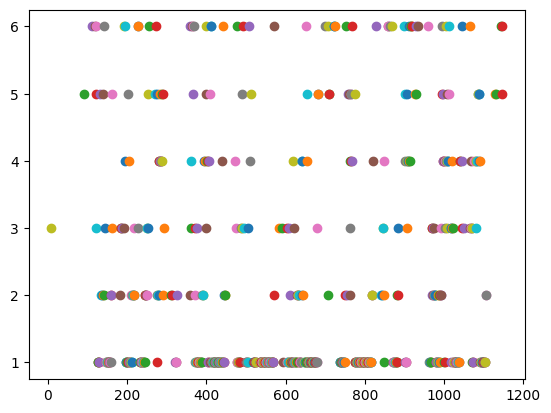

In [13]:
# Plot the frame when fall was detected for each person
for i in range(1, 7):
    for j in range(frame_length):
        if j in fall_frames[i]:
            plt.scatter(j, i)

plt.show()

### Nose coordinates difference

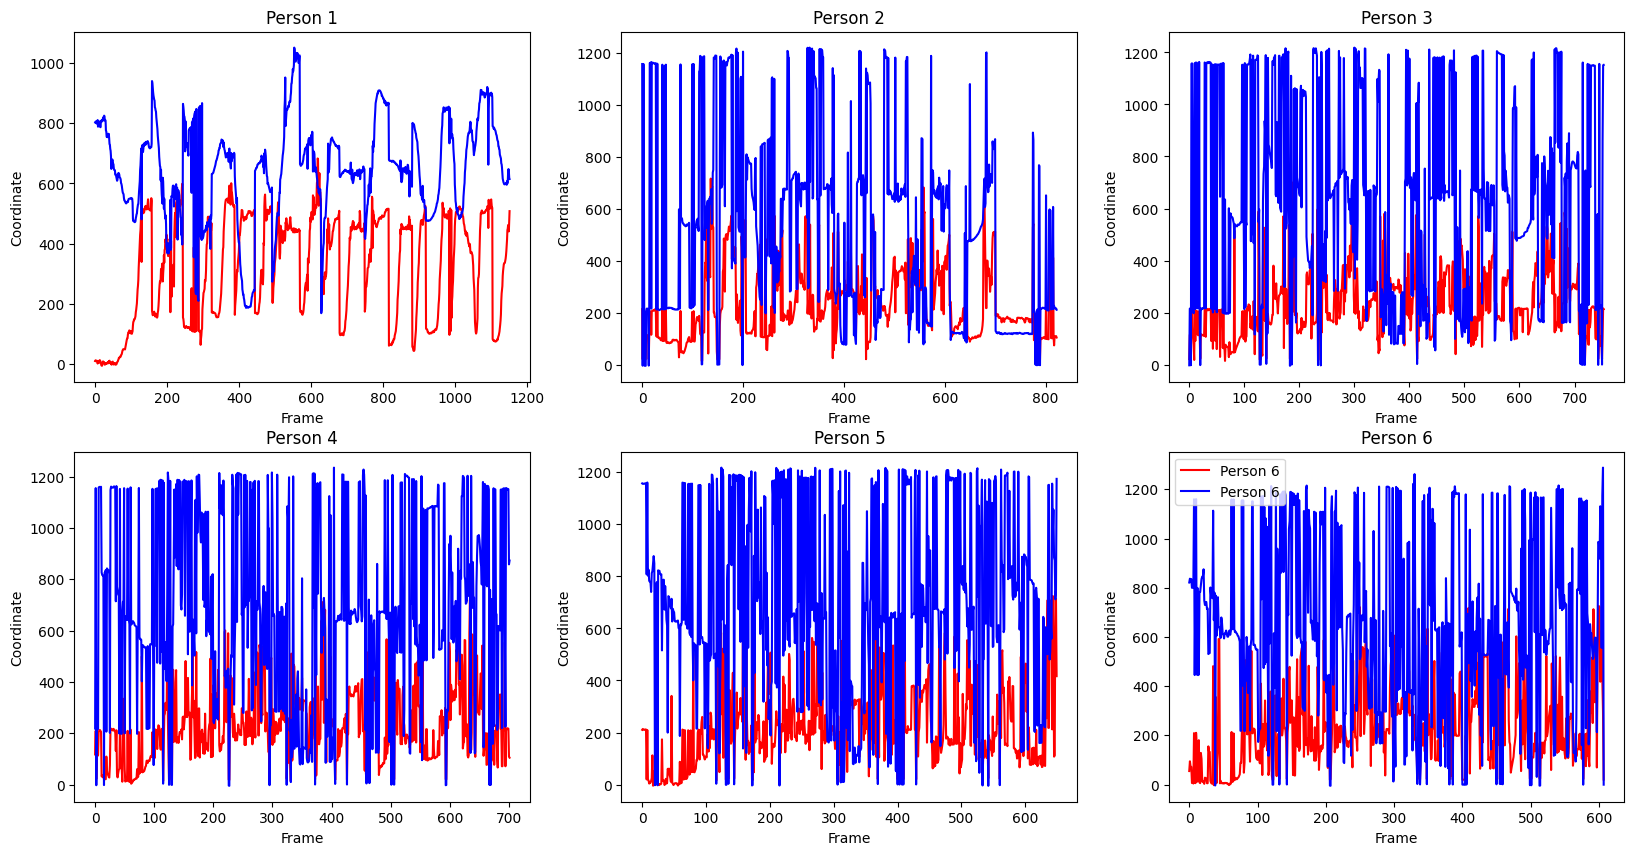

In [14]:
# Plot the x and y coordinates of the nose of each person
plt.figure(figsize=(20, 10))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.plot(y_coordinates[i], label=f'Person {i}', color='red')
    plt.plot(x_coordinates[i], label=f'Person {i}', color='blue')
    plt.title(f'Person {i}')
    plt.xlabel('Frame')
    plt.ylabel('Coordinate')
plt.legend()
plt.show()

### Aspects ratio

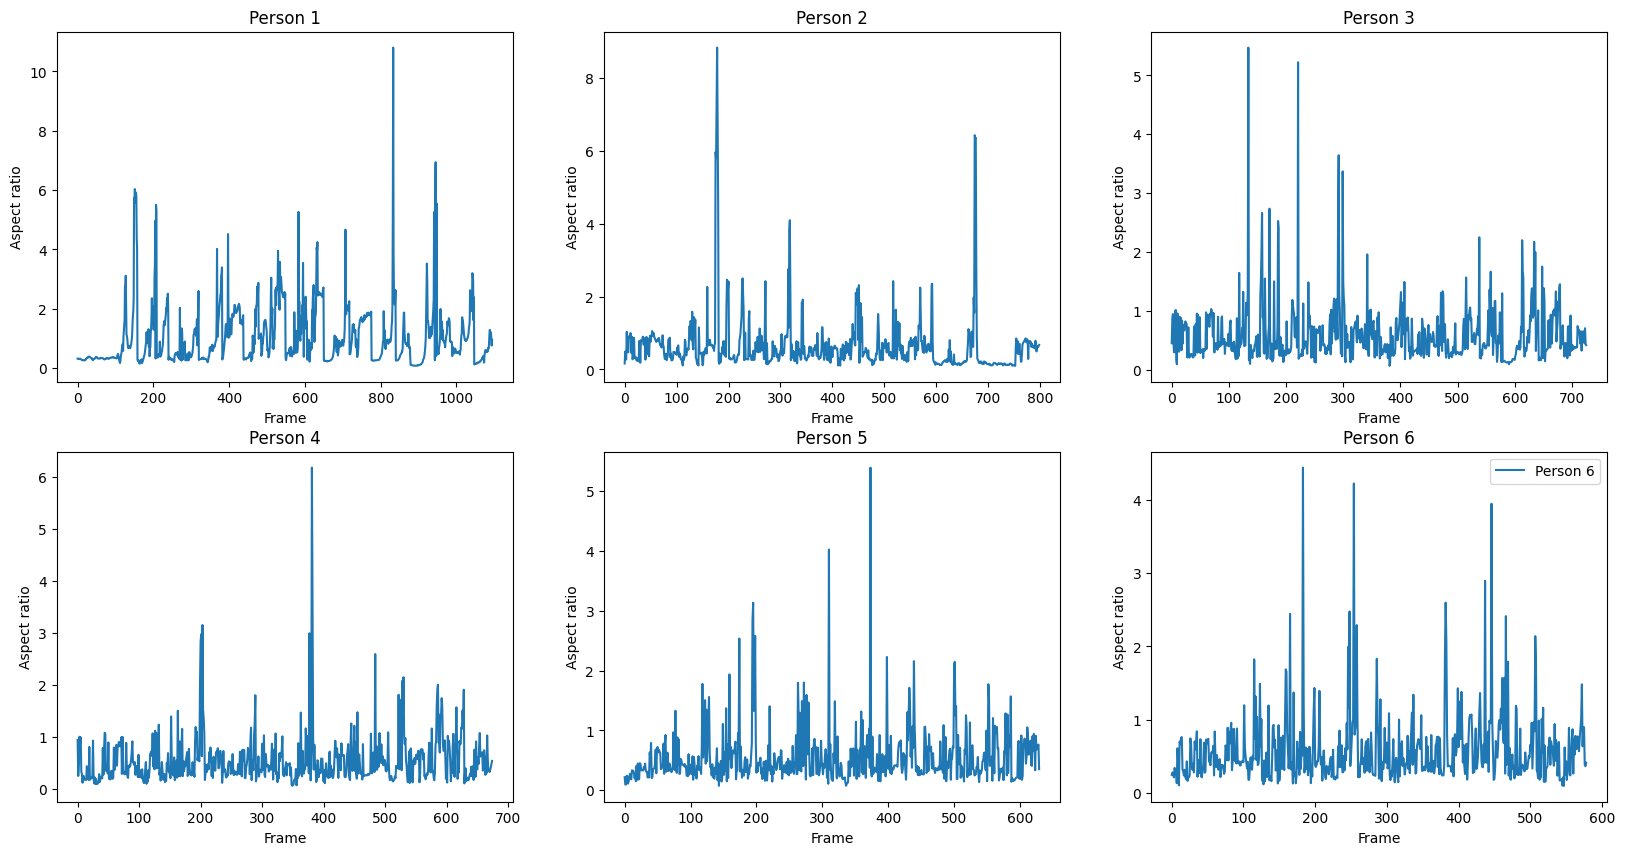

In [15]:
# Plot the aspect ratio of each person
plt.figure(figsize=(20, 10))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.plot(aspect_ratios[i], label=f'Person {i}')
    plt.title(f'Person {i}')
    plt.xlabel('Frame')
    plt.ylabel('Aspect ratio')
plt.legend()
plt.show()

### Angles of centroid with respect to horizontal axis of bounding box

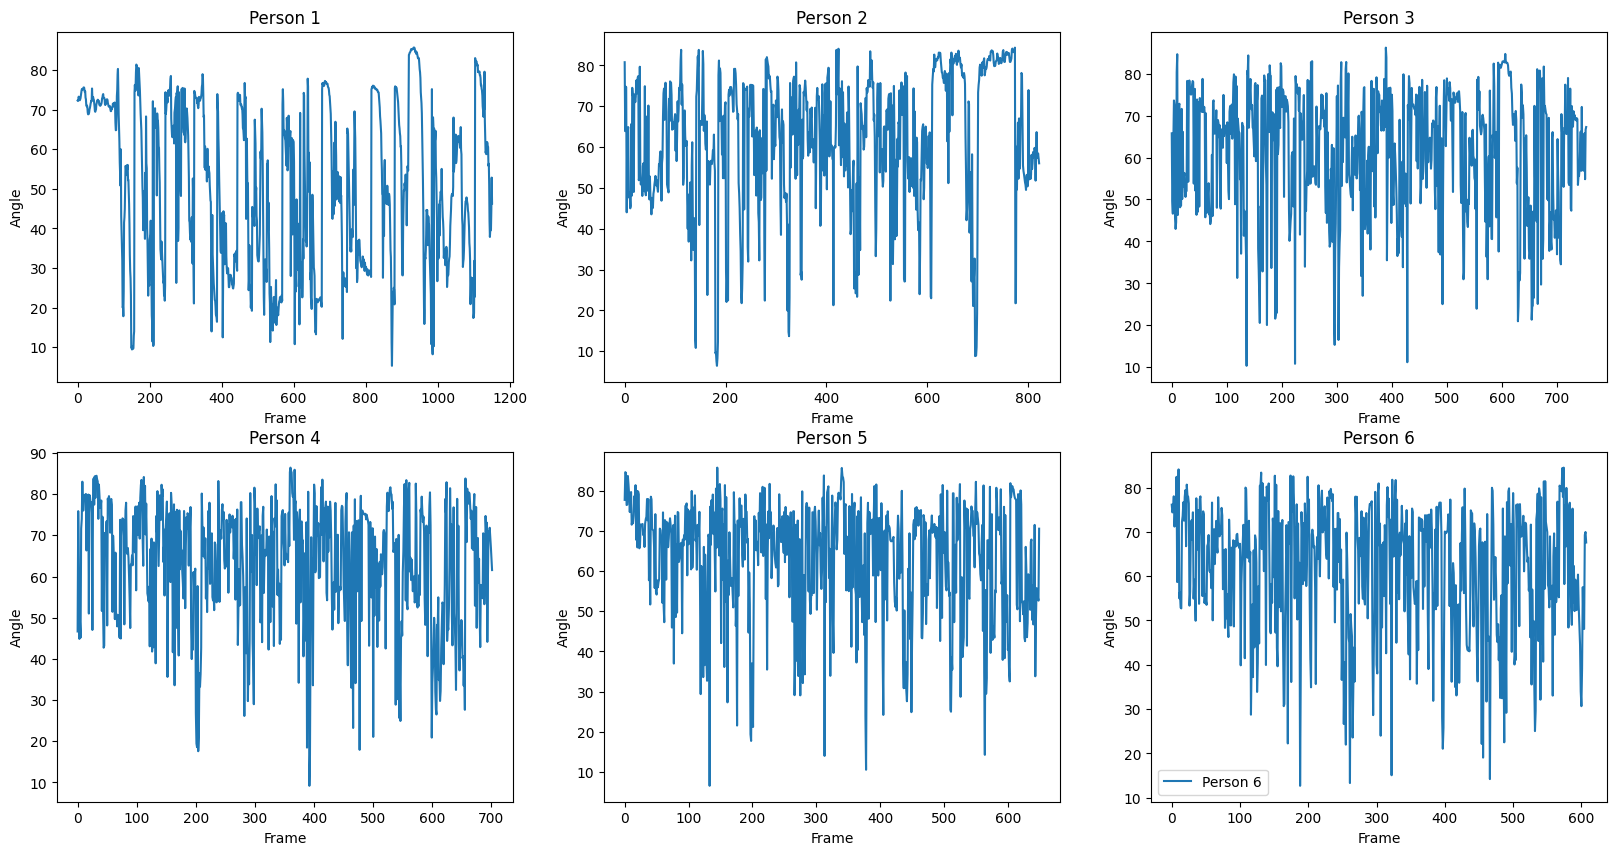

In [16]:
# Plot the angle of each person
plt.figure(figsize=(20, 10))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.plot(angles[i], label=f'Person {i}')
    plt.title(f'Person {i}')
    plt.xlabel('Frame')
    plt.ylabel('Angle')
plt.legend()
plt.show()

### First Person Analysis

Since on the sample video, there is only one person, we can analyze the data for one person only.

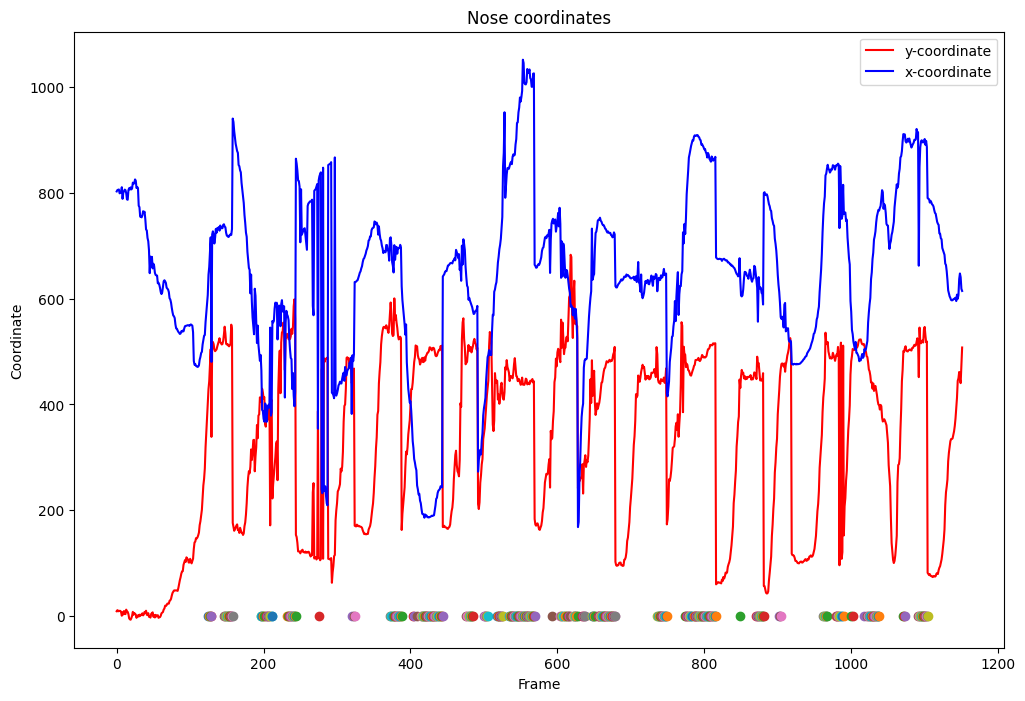

In [17]:
# Plot the x and y coordinates of the nose for the first person
plt.figure(figsize=(12, 8))
plt.plot(y_coordinates[1], label=f'y-coordinate', color='red')
plt.plot(x_coordinates[1], label=f'x-coordinate', color='blue')
for i in range(frame_length):
    if i in fall_frames[1]:
        plt.scatter(i, 1)
plt.title(f'Nose coordinates')
plt.xlabel('Frame')
plt.ylabel('Coordinate')
plt.legend()
plt.show()

When fall is detected, x coordinate tend to be higher than y coordinate. This is because when a person fall, the person will fall to the ground, which is at the bottom of the frame. This is shown in the graph above.

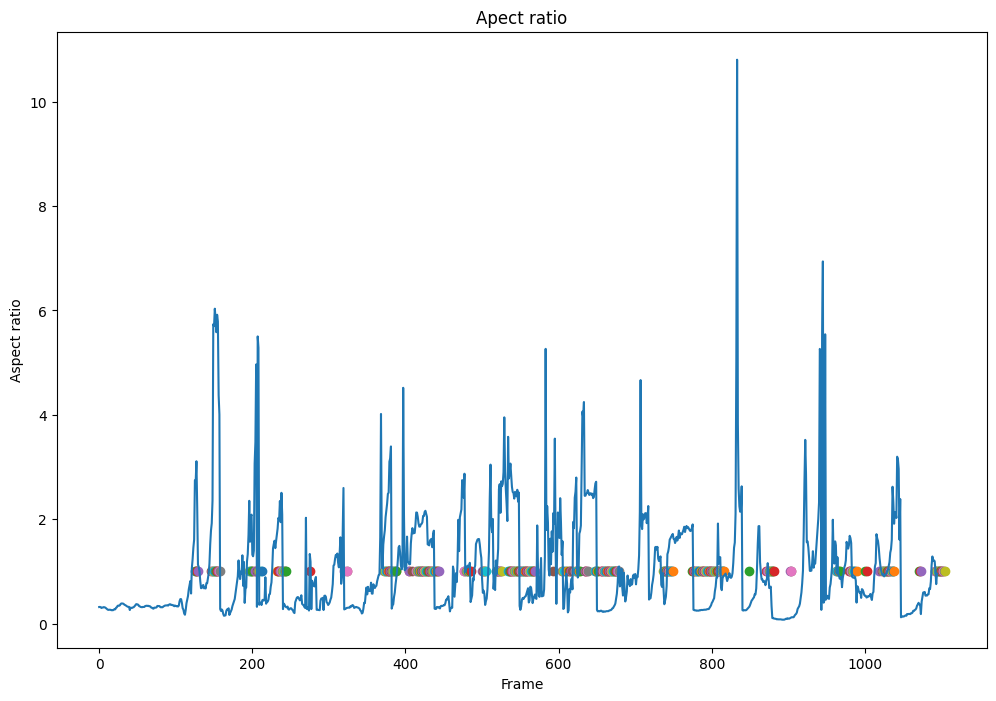

In [18]:
# Plot the aspect ratio for the first person
plt.figure(figsize=(12, 8))
plt.plot(aspect_ratios[1])
for i in range(frame_length):
    if i in fall_frames[1]:
        plt.scatter(i, 1)
plt.title(f'Apect ratio')
plt.xlabel('Frame')
plt.ylabel('Aspect ratio')
plt.show()

When fall is detected, the aspect ratio tend to change drastically. This is because when a person fall, the bounding box will change drastically. This is shown in the graph above.

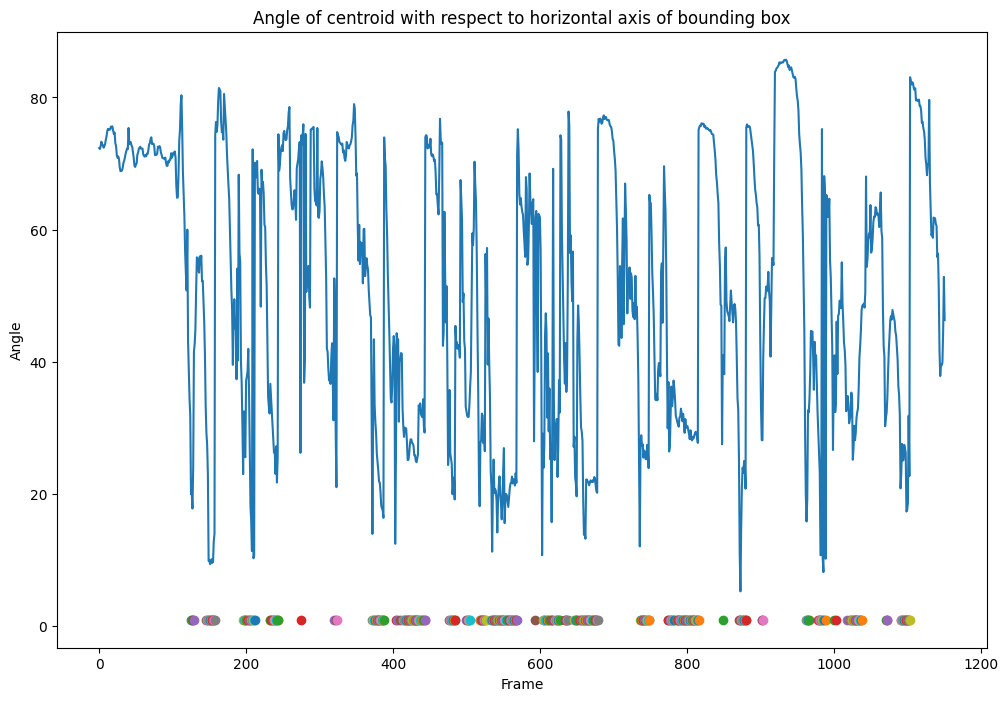

In [19]:
# Plot the angle for the first person
plt.figure(figsize=(12, 8))
plt.plot(angles[1])
for i in range(frame_length):
    if i in fall_frames[1]:
        plt.scatter(i, 1)
plt.title(f'Angle of centroid with respect to horizontal axis of bounding box')
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.show()

When fall is detected, the angle of centroid with respect to horizontal axis of bounding box tend to be lower than 45 degree. This is because when a person fall, the person will fall to the ground, which is at the bottom of the frame. This is shown in the graph above.